In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import sys
from torch_geometric.data import DataLoader, Dataset, Data
import lightning.pytorch as pl
import seaborn as sns
import pandas as pd
import os
from tqdm import tqdm
import torch
import itertools
import yaml
from pytorch_lightning.loggers import WandbLogger

import matplotlib.pyplot as plt

from epic_clustering.utils import plot_clusters, get_cluster_pos
from epic_clustering.models import MetricLearning

## 1. Load Model and Test Dataloading

In [2]:
input_dir = "/global/cfs/cdirs/m3443/data/PowerWeek/train/train"
csv_files = [os.path.join(input_dir, f) for f in os.listdir(input_dir) if f.endswith('.csv')]

In [3]:
events = pd.read_csv(csv_files[0])
event = events[events["event"] == events["event"].unique()[0]]

In [4]:
event

,event,hit_number,N,E,T,ix,iy,iz,posx,posy,posz,clusterID,Efrac,uniqueID
0,27000,0,1895,0.261049,17.51,82,60,0,117.543274,27.425,365.28000,11509158343811193875,1.0,-6937585729898357741
1,27000,1,1895,1.218229,12.57,38,42,0,-82.629840,-62.575,363.28000,17828652613631594586,1.0,-618091460077957030
2,27000,2,1895,0.983161,12.61,38,43,0,-82.629840,-67.425,365.28000,17828652613631594586,1.0,5343361554445887269
3,27000,3,1895,0.404564,12.57,45,42,0,-77.370160,-62.575,361.28000,17828652613631594586,1.0,-7175626205880516806
4,27000,4,1895,0.393017,13.46,39,43,1,-87.543280,-67.425,383.28000,17828652613631594586,1.0,-3965530794151426912
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1890,27000,1890,1895,0.001650,29.24,65,54,1,22.629840,-2.575,375.28000,12544480375981618535,1.0,-1052490910097309665
1891,27000,1891,1895,0.001650,21.49,63,64,0,12.629840,47.425,363.28000,12544480375981618535,1.0,8795265319944163564
1892,27000,1892,1895,0.001650,76.07,57,51,6,-17.370160,-27.425,471.27997,12544480375981618535,1.0,-5858943092489343794
1893,27000,1893,1895,0.001650,41.33,53,62,2,-37.370160,37.425,409.28000,12544480375981618535,1.0,-2881660248844868567


In [5]:
# Sorted event.E - get first 40
high_energy_hits = event.sort_values(by="E", ascending=False).iloc[:40]

In [16]:
# use torch meshgrid to get all pairs between high_energy_hits.hit_number and event.hit_number
pairs = torch.meshgrid(torch.from_numpy(high_energy_hits.hit_number.values), torch.from_numpy(event.hit_number.values))
# convert into a 2 x N array
pairs = torch.stack(pairs).reshape(2, -1).T

In [17]:
pairs

tensor([[ 609,    0],
        [ 609,    1],
        [ 609,    2],
        ...,
        [1373, 1892],
        [1373, 1893],
        [1373, 1894]])

In [18]:
pairs.shape

torch.Size([75800, 2])

In [ ]:
class EventDataset(Dataset):
    """
    The custom default dataset to load CSV events off the disk
    """

    def __init__(self, input_dir, num_events = None, hparams=None, transform=None, pre_transform=None, pre_filter=None, **kwargs):
        super().__init__(input_dir, transform, pre_transform, pre_filter)
        
        self.input_dir = input_dir
        self.hparams = hparams
        self.num_events = num_events
        self.scales = {
                    "E": 30.,
                    "T": 100.,
                    "posx": 200.,
                    "posy": 200.,
                    "posz": 500.,
                }
        
        self.csv_events = self.load_datafiles_in_dir(self.input_dir, self.num_events)

        print("Converting to PyG data objects")
        self.pyg_events = [self.convert_to_pyg(event[1]) for event in tqdm(self.csv_events)]
        
    def load_datafiles_in_dir(self, input_dir, num_events):

        # Each file is 1000 events, so need to load num_events//1000 + 1 files
        csv_files = [os.path.join(input_dir, f) for f in os.listdir(input_dir) if f.endswith('.csv')][:num_events//1000 + 1]
        events = pd.concat([pd.read_csv(f) for f in csv_files])
        if num_events is not None:
            events = events[events.entry < num_events]

        self.scale_features(events)

        return list(events.groupby('entry'))

    def convert_to_pyg(self, event):

        # Convert to PyG data object
        event = event.reset_index(drop=True)
        event = event.drop(columns=['entry'])

        data.edge_index = self.create_training_pairs(event)
        y = event.clusterID[data.edge_index[0]] == event.clusterID[data.edge_index[1]]
        node_features = torch.from_numpy(event[['posx', 'posy', 'posz', 'E']].to_numpy())
        edge_features = torch.cat([node_features[data.edge_index[0]], node_features[data.edge_index[1]]], dim=1)

        data = Data(
                        x = edge_features,
                        y = y
                    )

        data.num_nodes = data.x.shape[0]

        return data
        
    def len(self):
        return len(self.pyg_events)

    def get(self, idx):

        return self.pyg_events[idx]

    def scale_features(self, event):
        """
        Handle feature scaling for the event
        """

        for feature in self.scales.keys():
            event[feature] = event[feature]/self.scales[feature]

        return event

    def create_training_pairs(self, event):
        """
        Create the true edge list for the event. This is 
        """

        # Sorted event.E - get first 40
        high_energy_hits = event.sort_values(by="E", ascending=False).iloc[:40]

        # use torch meshgrid to get all pairs between high_energy_hits.hit_number and event.hit_number
        pairs = torch.meshgrid(torch.from_numpy(high_energy_hits.hit_number.values), torch.from_numpy(event.hit_number.values))
        # convert into a 2 x N array
        pairs = torch.stack(pairs).reshape(2, -1)

        return pairs

In [10]:
dataset = EventDataset(input_dir, num_events=100)

Converting to PyG data objects


100%|██████████| 100/100 [00:08<00:00, 11.81it/s]


In [12]:
# Split dataset into train val and test
from torch.utils.data import random_split

train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

## 3. Training Loop Test

In [2]:
with open("metric_learning_config.yaml", "r") as f:
    metric_learning_config = yaml.safe_load(f)
model = MetricLearning(metric_learning_config)
model.setup(stage="fit")

Converting to PyG data objects


100%|██████████| 220/220 [00:16<00:00, 13.49it/s]

Loaded 200 training events, 10 validation events and 10 testing events


In [3]:
logger = WandbLogger(project=metric_learning_config["project"])
trainer = pl.Trainer(devices=1, accelerator="gpu", max_epochs=100, logger=logger)
trainer.fit(model)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: murnanedaniel. Use `wandb login --relogin` to force relogin


/global/homes/d/danieltm/.conda/envs/powerweek/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /global/homes/d/danieltm/.conda/envs/powerweek/lib/p ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/global/homes/d/danieltm/.conda/envs/powerweek/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /global/homes/d/danieltm/.conda/envs/powerweek/lib/p ...
  rank_zero_warn(
You are using a CUDA device ('NVIDIA A100-

Sanity Checking: 0it [00:00, ?it/s]

/global/homes/d/danieltm/.conda/envs/powerweek/lib/python3.11/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/global/homes/d/danieltm/.conda/envs/powerweek/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 256 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

/global/homes/d/danieltm/.conda/envs/powerweek/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/logger_connector/result.py:212: UserWarning: You called `self.log('all_positive', ...)` in your `validation_step` but the value needs to be floating point. Converting it to torch.float32.
  warning_cache.warn(
/global/homes/d/danieltm/.conda/envs/powerweek/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/logger_connector/result.py:212: UserWarning: You called `self.log('all_true', ...)` in your `validation_step` but the value needs to be floating point. Converting it to torch.float32.
  warning_cache.warn(
/global/homes/d/danieltm/.conda/envs/powerweek/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/logger_connector/result.py:212: UserWarning: You called `self.log('true_positive', ...)` in your `validation_step` but the value needs to be floating point. Converting it to torch.float32.
  warning_cache.warn(


Best clustering score: 0.5082495566772185 at eps: 0.2
Sanity Checking DataLoader 0:  50%|█████     | 1/2 [00:01<00:01,  1.96s/it]Best clustering score: 1.0 at eps: 0.001


/global/homes/d/danieltm/.conda/envs/powerweek/lib/python3.11/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/global/homes/d/danieltm/.conda/envs/powerweek/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 256 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 0: 100%|██████████| 200/200 [00:02<00:00, 72.10it/s, v_num=k6tl]Best clustering score: 0.6580497561951528 at eps: 0.06733333333333334
Best clustering score: 1.0 at eps: 0.001
Best clustering score: 0.5402521409899165 at eps: 0.08944444444444445
Best clustering score: 0 at eps: 0


/global/homes/d/danieltm/.conda/envs/powerweek/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/logger_connector/result.py:212: UserWarning: You called `self.log('best_clustering_score', ...)` in your `validation_step` but the value needs to be floating point. Converting it to torch.float32.
  warning_cache.warn(
/global/homes/d/danieltm/.conda/envs/powerweek/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/logger_connector/result.py:212: UserWarning: You called `self.log('best_clustering_eps', ...)` in your `validation_step` but the value needs to be floating point. Converting it to torch.float32.
  warning_cache.warn(


Best clustering score: 0.6350990444595206 at eps: 0.08944444444444445
Best clustering score: 0.6767770394602192 at eps: 0.06733333333333334
Best clustering score: 1.0 at eps: 0.001
Best clustering score: 0.7063622293695647 at eps: 0.06733333333333334
Best clustering score: 0.6256282932074423 at eps: 0.06733333333333334
Best clustering score: 0.5178324455021855 at eps: 0.11155555555555556
Epoch 10: 100%|██████████| 200/200 [00:02<00:00, 72.44it/s, v_num=k6tl]Best clustering score: 0.6642721684085594 at eps: 0.06733333333333334
Best clustering score: 1.0 at eps: 0.001
Best clustering score: 0.6062086529657457 at eps: 0.08944444444444445
Best clustering score: 0 at eps: 0
Best clustering score: 0.6195682552953241 at eps: 0.11155555555555556
Best clustering score: 0.6260316480123889 at eps: 0.045222222222222226
Best clustering score: 1.0 at eps: 0.001
Best clustering score: 0.6306677179887805 at eps: 0.06733333333333334
Best clustering score: 0.6250426346575487 at eps: 0.06733333333333334


`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 200/200 [00:03<00:00, 62.09it/s, v_num=k6tl]


In [4]:
event = model.trainset[0]
true_edges = torch.cat([event.edge_index, event.edge_index.flip(0)], axis=1)

In [11]:
embedding = model.cuda()(event.x.cuda()).cpu().detach()
# pca embedding
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca_embedding = pca.fit_transform(embedding)

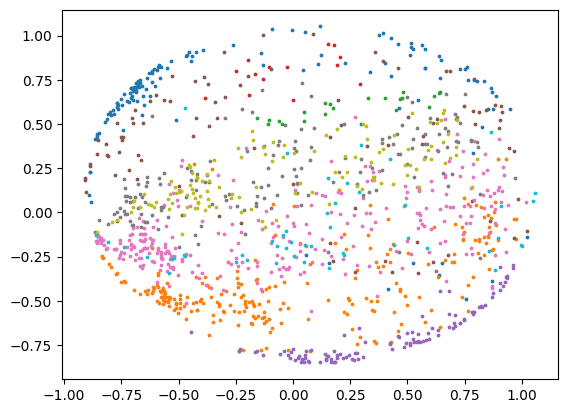

In [13]:
# Plot the embedding
for pid in event.pid.unique():
    plt.scatter(pca_embedding[event.pid == pid, 0], pca_embedding[event.pid == pid, 1], s=event[event.pid == pid, 3])

## Debug evaluation

In [3]:
event = model.trainset[0]
true_edges = torch.cat([event.edge_index, event.edge_index.flip(0)], axis=1)

In [19]:
for r in np.linspace(0.1, 0.8, 10):
    model.hparams["radius"] = r
    # Instantiate empty prediction edge list
    pred_edges = torch.empty([2, 0], dtype=torch.int64)

    # Append Hard Negative Mining (hnm) with KNN graph
    pred_edges = model.append_hnm_pairs(pred_edges, event.x[:, :2])

    truth = event.pid[pred_edges[0]] == event.pid[pred_edges[1]]

    true_pred_edges = pred_edges[:, truth.bool()]

    # Get totals
    all_positive = pred_edges.shape[1]
    all_true = true_edges.shape[1]
    all_true_positive = true_pred_edges.shape[1]

    # print(f"all_positive: {all_positive}, all_true: {all_true}, all_true_positive: {all_true_positive}")

    # Calculate metrics
    eff = all_true_positive / all_true 
    pur = all_true_positive / max(all_positive, 1)
    f1 = 2 * eff * pur / max(eff + pur, 1e-5)

    print(f"Radius: {r}, eff: {eff}, pur: {pur}, f1: {f1}")

Radius: 0.1, eff: 0.25250609849062355, pur: 0.7651962152640749, f1: 0.379711647079334
Radius: 0.17777777777777778, eff: 0.5427958403211872, pur: 0.7274215175055869, f1: 0.6216910380404433
Radius: 0.25555555555555554, eff: 0.6414135157798445, pur: 0.6977196164809536, f1: 0.6683828238646801
Radius: 0.33333333333333337, eff: 0.664260621537836, pur: 0.6753639522566978, f1: 0.669766272530457
Radius: 0.4111111111111111, eff: 0.6603728337653098, pur: 0.652969599703519, f1: 0.6566503509368976
Radius: 0.48888888888888893, eff: 0.6433987015297047, pur: 0.6233910317862106, f1: 0.6332368661476768
Radius: 0.5666666666666667, eff: 0.6304568785892158, pur: 0.6055432676907119, f1: 0.6177489857878021
Radius: 0.6444444444444445, eff: 0.623891472277278, pur: 0.5969698811658511, f1: 0.6101338485576101
Radius: 0.7222222222222222, eff: 0.6180184987548915, pur: 0.5883667449353414, f1: 0.6028282164824125
Radius: 0.8, eff: 0.6127934898612594, pur: 0.5784908868202596, f1: 0.5951483228127543


## 4. Evaluation Loop Test